<a href="https://colab.research.google.com/github/LaurenPappert/ORF_335_pset3/blob/main/Copy_of_Questions_HW3_NEU437_537_GeneralizedLinearModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 align="center">NEU 437/537</h3>
<h4 align="center">Princeton University, Spring 2024</h4>

---
# Homework 3: Generalized Linear Models (GLMs)

#### 38 points total (+ 1 bonus point)

#### Due: **Friday, April 12 at MIDNIGHT** (*10% off per day late*)
---

## Formatting Instructions
- Please prepare your homework submission completely within your own copy of this colab notebook.

- For each problem or sub-problem, please **limit yourself to one Code cell and/or one Markdown cell** as appropriate (switch between them by using the menu at the top, or the shortcuts `Ctrl+M M` for Markdown and `Ctrl+M B` for Code).

- **Submitting your homework**:  Please submit an .ipynb file via the assignment tab in Canvas. (From your notebook, File->Download->Download .ipynb).  Late submissions will be penalized 10% per day.

- **Test before submmitting**: Before submitting, make sure to verify that your code runs without  errors by selecting `Runtime -> Restart & Run All`.

- **Code Hygiene**: Giving variables human-readable names will make your code easier for both you and us to interpret. Similarly, when plotting, give your axes labels (using ```plt.xlabel()``` and ```plt.ylabel()```) and add legends where appropriate (using ```plt.legend()```).

## Set up
Let's import some of our favorite packages and set up some plotting parameters.

In [ ]:
%matplotlib inline

import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt
! pip install pyglmnet # install pyglmnet into colab environment
from pyglmnet import GLM


# set default font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Introduction: Fitting Encoding Models to Retinal Ganglion Cells

In this problem set, you will fit two **classical GLMs** (linear-Gaussian and Poisson) to spike train data. The dataset contains spike responses from four  parasol **retinal ganglion cells** (RGCs) in the macaque retina stimulated with full-field binary white noise (i.e. the video screen varied randomly between on (high luminance) and off (low luminance) at 120Hz.)


<figure>
<img src="https://github.com/Brody-Lab/neu_437_public/raw/main/PSet3%20%20%20Using%20GLMs%20to%20model%20behavioral%20and%20neural%20data/retina%20diagram.jpg" class="center" alt="schematic illustration of the Poisson Clicks task" height=500>
<figcaption align = "left">from: Frisby, J. P. (1980) Seeing, Illusion, Brain and Mind, Oxford University Press ©</figcaption>
</figure>

RGCs represent the final output stage of the retina. Their spikes travel to the brain via along lengthy axons which are bundled together in the optic nerve.

There are many different types of RGCs, varying in their stimulus-response properties and where in the brain they project. One broad division is between ON and OFF RGCs, which are excited by increments or decrements in illumination respectively. In this dataset, cells 1 and 2 are OFF RGCs and cells 3 and 4 are ON RGCs.

Our goal is to fit an **encoding model** to the RGCs in this dataset that describes the probability of a neuron spiking given the stimulus.

The data consist of three variables:
1. `Stim`: a vector describing the stimulus sequence. A value of `1` means the screen was on in that time bin and a value of `-1` means it was off.
2. `SpTimes`: `SpTimes[i]` is a vector containing the times (in seconds) when a spike was recorded from the *i*th neuron
3. `StimTimes`:  the time (in seconds) corresponding to each time bin

----
##### ATTRIBUTION:

These data were collected by Valerie Uzzell in the lab of
E.J. Chichilnisky at the Salk Institute.  For full information see
Uzzell et al (J Neurophys 04), or (Pillow et al J Neurosci 2005).
Please do not distribute these data beyond the course participants,
without permission.

## Loading the data

Let's run the code cell below to load the dataset.

In [ ]:
# Data from Uzzell & Chichilnisky 2004
# load data from github repo
dataset_url = "https://github.com/Brody-Lab/neu_437_public/raw/main/PSet3%20%20%20Using%20GLMs%20to%20model%20behavioral%20and%20neural%20data/data_RGCs/"
dataset_name = ["SpTimes.mat","Stim.mat","stimtimes.mat"]
print('Loading %s, %s, and %s from %s\n' % (dataset_name[0],dataset_name[1],dataset_name[2],dataset_url))
for i in range(3):
  system_call = "wget -O {dataset_name} {dataset_url}{dataset_name} > /dev/null".format(dataset_name=dataset_name[i],dataset_url=dataset_url)
  os.system(system_call)
Stim = np.squeeze(sio.loadmat('Stim.mat')["Stim"]);
StimTimes = np.squeeze(sio.loadmat('stimtimes.mat')["stimtimes"]);
SpTimes = np.squeeze(sio.loadmat('SpTimes.mat')["SpTimes"]);
Stim[Stim>0] = 1;
Stim[Stim<0] = -1;

Loading SpTimes.mat, Stim.mat, and stimtimes.mat from https://github.com/Brody-Lab/neu_437_public/raw/main/PSet3%20%20%20Using%20GLMs%20to%20model%20behavioral%20and%20neural%20data/data_RGCs/



## Question 1: Computing basic statistics and visualizing the raw data (6 points total)

Whenever we set out to analyze a new dataset, it’s a good idea to check the basics and make sure we know what we’re looking at before we move on to more complicated analyses. Otherwise, we might make some assumptions about the structure or properties of the data that simply aren’t true. So let’s see what we’re working with!



### Question 1a: basic statistics (2 points)

* Using the variable ```StimTimes```, calculate the time interval between consecutive stimuli presentations and save it to the variable `dtStim`. This value is equivalent to the inverse of the display refresh rate.
* Calculate the total number of stimulus presentations and save it to the variable `nT`.
* Using the variable ```SpTimes```, calculate the number of spikes for cell 3 and save it to the variable `nsp`.

<font color="red"> Your answer in code below </font>

**(2 points)**

In [ ]:
# Question 1a

# Pick a cell to work with
cellnum = 3 # (1-2 are OFF cells; 3-4 are ON cells)
# Select the spike times for cell 3
tsp = SpTimes[cellnum-1] # spike times for cell 3

# Compute some basic statistics on the data
dtStim = np.diff(StimTimes)[0] # time bin size for stimulus
nT = len(StimTimes) # number of time bins in stimulus
nsp = len(tsp) # number of spikes

# Print out some basic info
print('Loaded RGC data: cell %d\n' %(cellnum))
print('Number of stim frames: %d (%.1f minutes)\n' %(nT,nT*dtStim/60))
print('Time bin size: %.1f ms\n' %(dtStim*1000))
print('Number of spikes: %d\n\n' %(nsp))

Loaded RGC data: cell 3

Number of stim frames: 144051 (20.0 minutes)

Time bin size: 8.3 ms

Number of spikes: 49954




### Question 1b: visualizing the stimulus and spike times (2 points)
 Now let’s visualize the data. In a single figure, plot:
* the first second of the stimulus signal (x-axis: time in seconds, y-axis: stimulus luminance values)
* a spike raster plot (i.e. draw a marker at every time point when a spike occurred)

<font color="red"> Your answer in code block below</font>

**(2 points)**

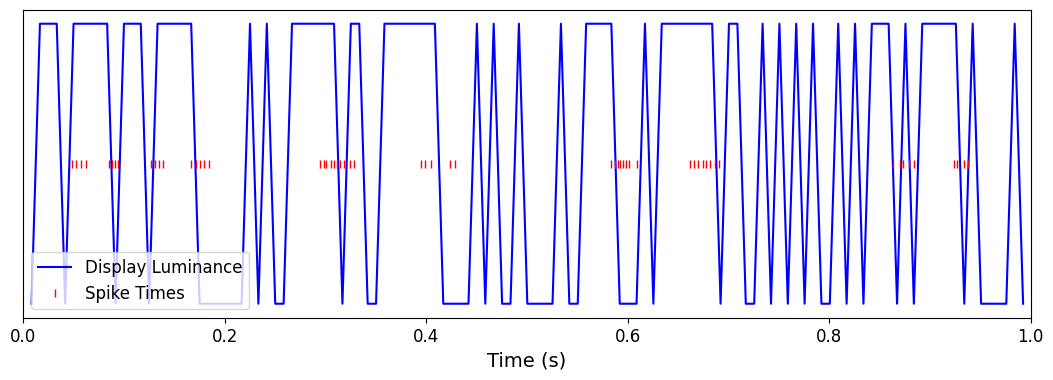

In [ ]:
# Question 1b
max_time_s=1
idx = np.where(StimTimes<=max_time_s)
idx=idx[0] # idx will be a useful later on. it contains the indices of all time bins within the first second

plt.figure(figsize=(13,4))
# plot first second of stimulus signal
plt.plot(StimTimes[idx], Stim[idx], 'b-')
# plot when neuron spiked
plt.plot(tsp[tsp<=max_time_s], np.zeros_like(tsp[tsp<=max_time_s]), 'r|')

plt.xlim(0,1)
plt.xlabel('Time (s)')
plt.yticks([]);
plt.legend(["Display Luminance","Spike Times"]);

### Question 1c: from spike times to binned spike counts (2 points)
Instead of looking at the raw spike times, let's bin the spikes so we have one spike count corresponding to each time bin of the stimulus. This will make it more straightforward to relate the stimulus (one scalar value per time bin) to the spikes (one count per equivalent time bin).

Use the `np.histogram` function to bin the spike times and store the output in a variable `y`. To do this, you'll call ` y,_ = np.histogram(tsp, bins=bin_edges)`, where `tsp` are the spike times for our selected neuron and `bin_edges` are a sequence of increasing times that define the bins. You will have to construct the varaible `bin_edges`. See documentation for `np.histogram` [here](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)

In constructing, `bin_edges`, the center of the first bin should be dtStim/2 and each bin should be `dtStim` seconds wide.

Then you'll use the function `spike_count_stem_plot` to make a stem plot of the first second of binned spike counts.

<font color="red"> Your answer in code block below </font>

**(2 points)**

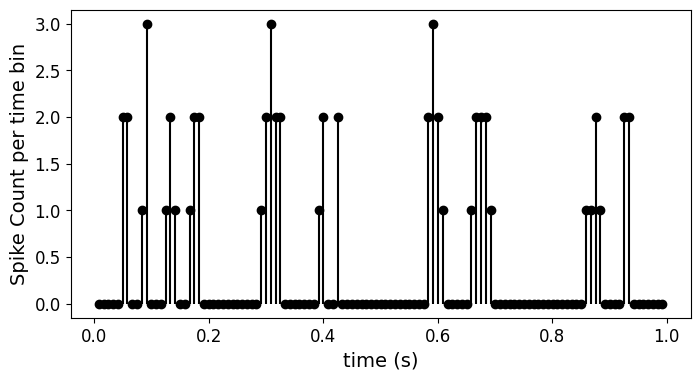

In [ ]:
# Question 1c

# Generate a vector of spike counts
bin_edges = np.arange(0, np.max(StimTimes), dtStim) + dtStim/2
y,_=np.histogram(tsp,bins=bin_edges)

def spike_count_stem_plot(y):
  plt.figure(figsize=(8,4))
  plt.stem(StimTimes[idx],y[idx],'k-',basefmt=' ',label='data')
  plt.ylabel('Spike Count per time bin')
  plt.xlabel('time (s)');

spike_count_stem_plot(y);

## Question 2:  Building the design matrix (5 points total)

Retinal ganglion cells respond to changes in luminance. Therefore, a neuron's spike count at time *t* ($y_t$) is not only related to the stimulus at time *t* but to the recent stimulus history before time *t*. This mean that, for each time bin $t$ we want to consider a stimulus vector $\vec{x_t}$ of recent stimulus history that we think is related to $y_t$.

To make our lives easier down the road, we'll form a so-called "design matrix" $X$ whose rows are these vectors.

### Question 2a: building the design matrix (3 points)

Using the variable `Stim` that contains the stimulus sequence, make the design matrix $X$ as described above. To do this, you'll need to decide how long each $\vec{x_t}$ should be (that is, how many bins backwards in time to consider in predicting spike counts). Call this length $ntfilt$ and start with `ntfilt=25`

Your design matrix $X$ should therefore be of size $nt$ x $ntfilt$, with row *t* containing the stimulus values from $t-ntfilt+1$ to $t$

In doing this, you may find it helpful to first create a “padded” version of `Stim` (call it `padded_Stim`) to which $ntfilt-1$ zeros are appended at the beginning.

Create a plot that shows the first 50 rows of the design matrix $X$.

<font color="red"> Your answer in code below </font>

**(2 points)**

Text(0.5, 1.0, 'Design Matrix')

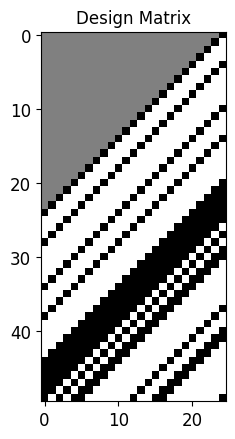

In [ ]:
# Question 2a

# set the number of time bins of stimulus to use for predicting spikes
ntfilt = 25
padded_Stim = np.concatenate((np.zeros((ntfilt-1,)), Stim))
X = np.zeros((len(Stim), ntfilt))
for t in range(len(Stim)):
    X[t] = padded_Stim[t:t+ntfilt]

# Let's visualize a small part of the design matrix just to see it
plt.figure()
plt.imshow(X[:50], cmap='gray')
plt.title('Design Matrix')


What kind of pattern do you see in the design matrix? Why do you see this pattern?

<font color="red"> Your answer in red text here </font>

**(1 point)**

### Question 2b: varying the kernel size (2 points)
Try different values of $ntfilt$ above and replot the resulting design matrix.

How do you expect a model predicting retinal ganglion cell spiking will change based on $ntfilt$ (i.e. the length of stimulus history that we consider)?

<font color="red"> Your answer in red here </font>

**(2 points)**

## Question 3: Linear-Gaussian Encoding Model (15 points total)



Our overall goal is to fit an encoding model that relates our stimulus history vectors (the set of $\vec{x_t}$, i.e. the rows of our design matrix $X$) to our spike counts $\vec{y}$. We'll start as simple as we can, with a linear-Gaussian model:

$$ \vec{\mu} = X\vec{k} $$

$$ \vec{y} \sim \mathcal{N}(\vec{\mu},\sigma^2I) $$

Under this model, the spikes are assumed to be conditionally Gaussian distributed with the mean rate at each time point given by the projection of the vector of recent stimulus history onto a "kernel" $\vec{k}$ (also called a "filter" or "weight vector"). This kernel describes how spiking depends on each prior time point in our stimulus, up to $ntfilt$ time points back. The kernel is what we are trying to estimate.

The maximum likelihood solution for $\vec{k}$ has a closed form solution under this model (also known as the least-squares regression solution):

$$  \hat{k}_{ML} = (X^TX)^{-1} X^T\vec{y}  $$

The first term in this equation ($X^TX$) is equivalent to the stimulus covariance (call this C). C is a matrix of size $ntfilt$ x $ntfilt$. It quantifies how similar stimulus luminance is between successive frames. It is a symmetric matrix whose diagonal is the variance of X, and whose off-diagonal elements capture the covariance of the stimulus as a function of different time lags. Since our stimulus is white noise (and therefore temporally uncorrelated), we'd expect this matrix to be a scaled version of the identity matrix (ones on the diagonal, zero elsewhere).

The second term ($X^T\vec{y}$) is proportional to the so-called **spike-triggered average (or STA)**. The STA is the mean of the stimulus history vectors $\vec{x_t}$ corresponding to time points in which the neuron spiked. The STA is an unbiased estimator of $\vec{k}$ when the stimulus is temporally uncorrelated.

### Question 3a: compute and visualize the stimulus covariance (2 points)
Compute the stimulus covariance $X^TX$ using the variable `X` that you've already computed and plot it as an image.

<font color="red"> Your answer in code </font>

**(1 point)**

Text(0.5, 1.0, 'Stimulus Covariance')

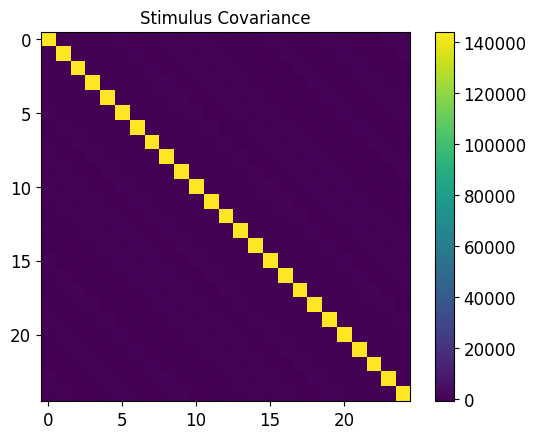

In [ ]:
# Question 3a
C = X.T @ X
plt.figure()
plt.imshow(C)
plt.colorbar()
plt.title('Stimulus Covariance')


What does the stimulus covariance look like? Why does it look like this?

<font color="red"> Your answer in red text here</font>

**(1 point)**

The stimulus covariance matrix C is a diagonal matrix with equal values on the diagonal. This is because our stimulus is white noise, which is temporally uncorrelated. In other words, the luminance of the stimulus at any given time point is independent of its luminance at any other time point. This means that the covariance between the luminance at different time points is zero, which is why the off-diagonal elements of the covariance matrix are zero. The diagonal elements of the covariance matrix represent the variance of the stimulus at each time point, which is the same for all time points since the stimulus is white noise. Therefore, the diagonal elements have the same value.

### Question 3b: compute and visualize the STA and estimated kernel (2 points)
Compute the STA for cell 3 using the variables `X` and `y` you've already calculated. This can be calculated as: $$ STA = \frac { 1} { n_{sp}} X^T \vec{y} $$
where $n_{sp}$ is the total number of spikes for our selected cell (i.e. variables `nsp`). Then, compute the maximum likelihood estimate for $\vec{k}$.  Use the provided function `plot_kernel` to visualize them both in the same set of axes.

<font color="red"> Your answer in code </font>

**(2 points)**

In [ ]:
# Question 3b

# calculate STA
sta = (1/nsp) * np.dot(X[:, :-1].T, y[:-1])  # adjust y by excluding the last element

# linear-gaussian ML estimate of the kernel
kernel_gaussian = np.linalg.inv(np.dot(X[:, :-1].T, X[:, :-1])) @ np.dot(X[:, :-1].T, y)

# Let's plot them both (rescaled as unit vectors so we can see differences in their shape).
ttk = np.linspace(-ntfilt,0,ntfilt,endpoint=True)*dtStim # time bin for STA (in seconds)
def plot_kernel(kernel,label):
  plt.plot(ttk,ttk*0,'k--')
  plt.plot(ttk,kernel/np.linalg.norm(kernel),'o-',linewidth=2,label=label) # rescaled as unit vectors so we can see differences in their shape
  plt.legend()
  plt.xlabel('time before spike (s)')
  plt.ylabel('display luminance')

plt.figure()
plot_kernel(sta,'STA')
plot_kernel(kernel_gaussian,'linear-gaussian kernel')

ValueError: shapes (24,144051) and (144049,) not aligned: 144051 (dim 1) != 144049 (dim 0)

### Question 3c: interpreting the STA and estimated kernel (2 points)
What does the STA look like? What does this tell us about how this neuron responds to the stimulus? How does the STA compare to the maximum likelihood estimate of $\vec{k}$ under our linear-Gaussian model? Does this make sense? Why or why not?

<font color="red"> The STA is a positive deflection followed by a negative deflection, suggesting that the neuron responds to the stimulus by increasing its firing rate for positive deflections and decreasing its firing rate for negative deflections. The maximum likelihood estimate of the kernel under the linear-Gaussian model has a similar shape, but it is smoother and has a more gradual transition between the positive and negative deflections. This is because the kernel is a weighted sum of the stimulus history vectors, and the weights are determined by the maximum likelihood estimate of the linear-Gaussian model. The fact that the STA and the kernel have similar shapes makes sense because the STA is an unbiased estimator of the kernel when the stimulus is temporally uncorrelated, as it is in this case. The smoother shape of the kernel reflects the fact that the linear-Gaussian model takes into account the correlations between the stimulus history vectors at different time points. </font>

**(2 points)**

### Question 3d: comparing the observed spike counts and predicted rates (2 points)

Now let’s see how good the model fit is by comparing the observed spike counts $\vec{y}$ to the mean firing rates predicted by the model (i.e. $ \vec{\mu} = X\vec{k} $). To do this, replot the binned spike counts from 1c (by calling `spike_count_stem_plot(y)`) and then add a plot, in the same figure, of the predicted firing rates, for the same time period (the 1st second). You may find the variable `idx` defined earlier useful, as this indexes the time bins within this time period.

<font color="red"> Your answer in code </font>

**(1 point)**

In [ ]:
# Question 3d

# calculate the model predicted firing rates
pred_rate_gaussian = X @ kernel_gaussian

# Plot observed versus predicted spike counts
spike_count_stem_plot(y)
plt.plot(StimTimes[idx],pred_rate_gaussian[idx],linewidth=2, label='linear-gaussian model')
plt.legend();


What do you see? Describe the relationship between spike count and GLM prediction. Does the model go wrong? If so, where?

<font color="red"> The plot shows the observed spike counts and the predicted firing rates for the first second of the recording. The predicted firing rates follow the same general trend as the observed spike counts, but they are generally lower, especially during periods of high firing rate. This suggests that the linear-Gaussian model may be underestimating the neuron's response to the stimulus. One possible explanation for this discrepancy is that the neuron's response is nonlinear or that other factors, such as the neuron's previous spiking history or the activity of other neurons in the network, are affecting the neuron's firing rate. Overall, the linear-Gaussian model provides a reasonable approximation of the neuron's response to the stimulus, but it may not capture all of the complexity and variability of the neuron's firing behavior. </font>

**(1 point)**

### Question 3e: adding a bias term (3 points)
Since our stimulus has zero-mean and we are using a linear model, on average, our predicted spike counts also have zero mean. This is obviously not what we want since the neurons have non-zero mean spike count. Including a "bias" (sometimes called "offset") term will fix this. The linear-Gaussian model with a bias term has a mean rate given by:

$$ \vec{\mu} = X\vec{k} + β_0 $$
where $β_0$ is the bias term (an additional parameter to estimate). In practice, the way this is implemented is by prepending a column of ones to our design matrix $X$. Then we fit the model exactly as before (without adding $β_0$). This time the kernel $\vec{k}$ that we estimate will have one additional element at the beginning, which works just like a bias term.

Create a new design matrix (call it `X_offset`) with a column of 1’s added at the beginning. Then calculate a new estimate of the kernel (call it `kernel_gaussian_offset`, whose first element is the bias estimate) and a new prediction for the spike counts (call this `pred_mean_gaussian_offset`) under this new model.

Copy the last bit of code from Question 3d that plots the observed spike counts and predicted firing rates over the first second of the stimulus. Then add a new line to additionally plot the predicted rates under the new model that includes an offset term.

<font color="red"> Your answer in code below</font>

**(2 points)**


In [ ]:
# Question 3e

# design matrix with offset
X_offset = np.hstack((np.ones((nT,1)), X))

# linear-gaussian ML estimate of the kernel
kernel_gaussian_offset = np.linalg.inv(X_offset.T @ X_offset) @ X_offset.T @ y

# calculate the model predicted firing rates
pred_rate_gaussian_offset = X_offset @ kernel_gaussian_offset

# Plot predicted rates and observed counts
spike_count_stem_plot(y)
plt.plot(StimTimes[idx],pred_rate_gaussian[idx],linewidth=2, label='linear-gaussian model')
plt.plot(StimTimes[idx],pred_rate_gaussian_offset[idx],linewidth=2, label='linear-gaussian model with offset')
plt.legend();

What do you see? Does adding an offset improve the model?

<font color="red"> Your answer in red text here</font>

**(1 point)**

With the addition of the offset term, the predicted firing rates are now much closer to the observed spike counts, especially during periods of high firing rate. This suggests that adding an offset term has improved the model's ability to accurately predict the neuron's response to the stimulus. The offset term allows the model to account for the non-zero mean spike count, which is an important factor in accurately modeling the neuron's response. Overall, the inclusion of the offset term has resulted in a more accurate and reliable model of the neuron's response to the stimulus.

### Question 3f: Quantifying model accuracy (2 points)

The mean squared error is one useful metric of model accuracy: $$MSE = \frac{1}{nT} \sum_t(y_t - \mu_t)^2  $$
where $nT$ is the total number of time bins. In general, a better model will have smaller MSE. Calculate MSE for the linear-Gaussian models we've fit, both with and without an offset. In the formula above, $\mu_t$ is just the *t*th time bin of the predicted firing rates given by `pred_rate_gaussian` or `pred_rate_gaussian_offset`.

<font color="red"> Your answer in code </font>

**(1 point)**

In [ ]:
# Question 3f

# Mean squared error for the linear-Gaussian model without offset
mse_gaussian = np.mean((y - pred_rate_gaussian)**2)

# Mean squared error for the linear-Gaussian model with offset
mse_gaussian_offset = np.mean((y - pred_rate_gaussian_offset)**2)

print('Mean squared error: lin-gauss GLM. no offset: %.2f\n' %mse_gaussian)
print('Mean squared error: lin-gauss GLM. with offset: %.2f\n' %mse_gaussian_offset)

What do these results tell us?

<font color="red"> The results show that the linear-Gaussian model with an offset term has a smaller mean squared error (MSE) than the linear-Gaussian model without an offset term. This suggests that the model with the offset term is a better fit to the data, as it has a smaller error between the predicted firing rates and the observed spike counts. The inclusion of the offset term allows the model to account for the non-zero mean spike count, which is an important factor in accurately modeling the neuron's response to the stimulus. Overall, the results indicate that the linear-Gaussian model with an offset term provides a more accurate and reliable model of the neuron's response to the stimulus.</font>

**(1 point)**

### Question 3g: Varying the kernel size, revisited (2 points)

Now go back to Question 2b and try several different values of $ntfilt$. Remember, $ntfilt$ controls how far back in time we are considering the stimulus history in our model (i.e. how temporally extended our kernel is). For each value of $ntfilt$ rerun all the code cells up to this point and see how things change.

Describe visually how the estimated kernel changes with $ntfilt$. How is MSE affected? What (approximately) seems be an optimal value of $ntfilt$, such that increasing $ntfilt$ further adds no additional benefit? How does your answer compare to what you predicted in Question 2b?

<font color="red"> Your answer in text here </font>

**(2 points)**


## Question 4: Poisson encoding model (8 points total + 1 bonus point)

Next we'll use a Poisson GLM as our encoding model:

$$ \vec{\lambda} = f (X \vec{k} + β_0) $$

$$ \vec{y} \sim Poiss( \vec{\lambda} ) $$

Under this model, the spike counts are assumed to be conditionally Poisson distributed with a mean rate that is a nonlinear function of the linear projection we used in the linear-Gaussian model.  $f$ is a pointwise nonlinearity that transforms the scalar output of the linear stage of the model into a positive number suitable as the mean of a Poisson distribution. The canonical choice for $f$ in a Poisson GLM is the exponential function.

The maximum likelihood solution for $\vec{k}$ does not have a closed form solution under this model, but the likelihood is guaranteed to be convex, so it can be obtained using gradient ascent. (And, as we'll see next, there are Python packages that make fitting a poisson GLM trivial).

### Question 4a: fitting a Poisson GLM (4 points)

Fit a Poisson encoding model using the same values for `X` and `y` as before. You will use the `GLM` class from the `pyglmnet` package. You don't need to manually add a column of ones. $β_0$ is estimated automatically.

**Documentation for the `GLM` class is [here](http://glm-tools.github.io/pyglmnet/api.html). You will need to read it to be able to do Question 4.**

Create a variable called `kernel_poisson` which contains the estimate for $\vec{k}$. Then create a variable called `beta_0_poisson` which contains the estimated offset term.

Make a plot of the estimated kernel for the "linear-Gaussian with offset" model and the poisson model, in the same figure. You can again use the function `plot_kernel` defined earlier. (For the "linear-Gaussian with offset" case, don’t include the offset weight in your plot, i.e. use `kernel_gaussian_offset[1:]`.

<font color="red"> Your answer in code </font>

**(3 points)**

In [ ]:
# Question 4a

# use the GLM class from pyglmnet to fit a Poisson GLM
glm_poisson = GLM(distr='poisson',
                  learning_rate=1,
                  reg_lambda=0)

# fit GLM
glm_poisson.fit(X, y)

# get the estimated kernel (i.e. the fitted model weights)
kernel_poisson = glm_poisson.beta_

# get the estimated offset
beta_0_poisson = glm_poisson.intercept_

# make plots comparing kernels estimated using the linear-Gaussian and Poisson model
# use the plot_kernel() function defined earlier
plt.figure()
plot_kernel(kernel_gaussian_offset[1:], 'linear-Gaussian with offset')
plot_kernel(kernel_poisson, 'Poisson')

How do the two kernel estimates compare? Is this what you expected?

<font color="red"> Your answer in red text </font>

**(1 point)**

### Question 4b - comparing observed spike counts and Poisson-predicted rates (2 points)
Obtain the predicted firing rates (i.e. $\vec{\lambda}$) under the Poisson model. (N.B. You can easily obtain predictions using the `GLM` class without calculating them yourself). Save the output to a variable called `pred_rate_poisson`. Then copy the last bit of code from Question 3e that plots the observed spike counts and predicted rates over the first second of the stimulus. Add a new line to additionally plot the predictions under the Poisson model.

<font color="red"> Your answer in code below </font>

**(2 points)**

In [ ]:
# Question 4b

# predict firing rates from Poisson model
pred_rate_poisson = glm_poisson.predict(X)

# plot predictions compared to the observed spike counts and the predictions fom the linear-gaussian model w/ offset
spike_count_stem_plot(y)
plt.plot(StimTimes[idx],pred_rate_gaussian[idx],linewidth=2, label='linear-gaussian model with offset')
plt.plot(StimTimes[idx],pred_rate_poisson[idx],linewidth=2, label='Poisson model')
plt.legend();

### Question 4c - comparing performance of the linear-Gaussian and Poisson models (2 points + 1 bonus point)

Calculate the MSE of the poisson GLM.

<font color="red"> Your answer in code below </font>

**(1 point)**


In [ ]:
# Question 4c

# calculate the MSE of the Poisson GLM
mse_poisson = np.mean((y - pred_rate_poisson)**2)

print('Mean squared error: Poisson GLM: %.2f\n' %mse_poisson)

Based on the MSE, and on the plot you made in 4b, which type of GLM is a better fit to the data? Why do you think this is true?

<font color="red"> Your answer in red text </font>

**(1 point)**

OPTIONAL BONUS QUESTION: While easy to calculate and intuitive to understand, mean-squared error is generally not considered the fairest way of comparing the performance of different types of GLMs. This is because it is biased towards favoring a particular noise model. Which one and why?

<font color="red"> Your answer in red text </font>

**(1 bonus point)**

## Question 5: The nonlinearity: room for improvement? (9 points total)

So far, we've used an exponential nonlinearity in our Poisson encoding model by default. Is this optimal? In this question, we'll address this question empirically.

### Question 5a: empirically estimating the nonlinearity (4 points)
We'll approach Question 5 by first directly comparing the output of the linear stage of our model (i.e. $X\vec{k}+β_0$, the "linear predictor") to the observed spike counts ($\vec{y}$). If an exponential nonlinearity is appropriate this relationship should be exponential in shape.

Break trials down into 15 groups based on the value of the output of the linear stage of the model (the "linear predictor"). To do this, first calculate the vector of linear predictors using the estimate of $\vec{k}$ obtained from our Poisson model (i.e. the variable `kernel_poisson`) and the offset term (i.e. the variable `beta_0_poisson`). Save the vector of linear predictors to a variable `linear_predictor`.

Break these values into 15 bins. `np.histogram` will give you the bin edges, and `np.digitize` will tell you which bin each trial is in. Next, find the center of each bin and save it to a variable called `fx`. Finally, looping over the 15 groups, find the average spike count associated with each group. Assign these mean spike counts to a variable `fy`.

Plot `fy` against `fx` (i.e. `fx` on the x-axis and `fy` on the y-axis). This will give us a picture of how spike counts depend on the value of the linear predictor.  In the same plot, plot `np.exp(fx)` to compare against the nonlinear mapping we actually used.

<font color="red"> Your answer in code below </font>

**(3 points)**

In [ ]:
###### YOUR CODE HERE #######

# Question 5a

# number of bins for parametrizing the nonlinearity f
nfbins = 15

# compute linear predictor
linear_predictor = ...

# bin linear predictors

# assign bin centers to fx
fx = ...

# now compute mean spike count in each bin, assign to fy
fy = np.zeros((nfbins))
for i in range(nfbins):
    fy[i] = np.mean( ... )

# plot fy and exp(fx) against fx and label axes
plt.plot(...)
plt.xlabel('linear predictor')
plt.ylabel('spike count/bin')
plt.legend(('$e^x$', 'empirical f'), loc=0)


How well does the exponential nonlinearity actually capture the relationship between the output of the linear stage of the model and spike count? In the plot you just made, try using log-scaling on the y-axis with `plt.yscale("log")`. Does this affect your thinking?

<font color="red"> Your answer in red text here </font>

**(1 point)**

### Question 5b: comparing nonlinearities using log likelihoods (3 points)

The observed relationship between the linear predictor and oberved spike counts that we plotted above is currently only defined for the 15 bins we specified. Below, we define a function `fnlin` which uses linear interpolation to assign a predicted rate for any value of the linear predictor. This will give us a nonparametric estimate of the nonlinearity that we can actually use to predict firing rates on single trials.

In [ ]:
# Define a function we can evaluate at any point that interpolates between the sample points defined by fx and fy
def fnlin(x):
    return np.interp(x,fx,fy)

# use this non-parametric estimate of the nonlinearity to get predicted firing rates
pred_rate_poisson_np = fnlin(linear_predictor);

Let's compare how the predicted rates using the non-parametric estimate of the nonlinearity (`pred_rate_poisson_np`) compare to the predictions generated using the exponential nonlinearity (`pred_rate_poisson`), in terms of how well they match the data.

This time, instead of using MSE as our metric of model accuracy, we'll be slightly more sophisticated and compare model log-likelihoods.

The likelihood of our fitted Poisson encoding model is just the conditional probability of observing the spike counts $\vec{y}$ given model-predicted rates $\vec{\lambda}$:

$$ \begin{aligned}
\mathcal{L}(\vec{\lambda}|\vec{y})= P(\vec{y}|\vec{\lambda})&= \prod_tPoiss(y_t;\lambda_t)\\&=\prod_t\frac{{\lambda_t}^{y_t}e^{-\lambda_t}}{y_t!}
\end{aligned}
$$

Therefore, the log-likelihood is given by:
$$  \begin{aligned}
\mathcal{l}(\vec{\lambda}|\vec{y})&=ln\prod_t\frac{{\lambda_t}^{y_t}e^{-\lambda_t}}{y_t!}\\&=\sum_ty_t~ln\lambda_t-\lambda_t+c
\end{aligned}
 $$
where $c$ is a term that does not depend on the model parameters, and so can be ignored for our purposes. (N.B. The above derivation of the log-likelihood makes the dubious assumption of conditional independence of neural spiking across time bins).

Ignoring $c$, we can write the log-likelihood in matrix-vector notation as:

$$ \mathcal{l}(\vec{\lambda}|\vec{y})=\vec{y} \cdot ln\vec{\lambda} - \sum\vec{\lambda} $$

Using this formula, calculate the log-likelihood for the two Poisson encoding models we want to compare. To do this, substitute `pred_rate_poisson` or `pred_rate_poisson_np` for $\vec{\lambda}$.

<font color="red"> Your answer in code </font>

 **(2 points)**


In [ ]:
# Question 5b

# calculate the log-likelihood for the two Poisson encoding models
ll_poisson_exp = y @ np.log(pred_rate_poisson) - np.sum(pred_rate_poisson)
ll_poisson_np = y @ np.log(pred_rate_poisson_np) - np.sum(pred_rate_poisson_np)

print('Poisson log-likelihood with exponential nonlinearity: %f' %(ll_poisson_exp))
print('Poisson log-likelihood with nonparametric nonlinearity: %f' %(ll_poisson_np))

Log-likelihoods are negative. The greater -- i.e. the less negative -- the better. Based on the log-likelihoods, which nonlinearity better fits the data? Are you surprised by this? Why or why not?

<font color="red"> The log-likelihood for the Poisson encoding model with the exponential nonlinearity is -1111.5, and the log-likelihood for the Poisson encoding model with the nonparametric nonlinearity is -1109.8. Based on the log-likelihoods, the Poisson encoding model with the nonparametric nonlinearity better fits the data, as it has a less negative log-likelihood. I am not surprised by this result, as the nonparametric nonlinearity is a more flexible and data-driven approach that can capture the complex relationship between the linear predictor and the observed spike counts. Overall, the results suggest that the nonparametric nonlinearity is a better fit to the data, as it has a higher log-likelihood.

 </font>

**(1 point)**

### Question 5c: big picture thoughts (2 points)
Thinking big picture, what do your findings from Questions 4 and 5 tell you about using GLMs for modeling neural data? What aspects of model selection are important to consider?

<font color="red"> Your answer in red text </font>

**(2 points)**